# Product Pricing Chart Case Study

- Product A has a raw material cost of around 7 and takes about 30 - 45 minutes of processing time to complete.
- Product starts at 35 dollars and vendor is charging 5 dollars for each additional color used in construction.

### Generating Test Data

- Product has 3 parameters which can be customized for each user basis. Length, Weight, and Color.
- In my generated test data I am maxing out on a length of 20 inches.

In [312]:
import matplotlib.pyplot as plt
# products start at $35 and cost $5 extra for each additional color
import numpy as np
import pandas as pd
# Initial values provided by client
MATERIAL_PRICE = 7
BASE_PRICE= 35
COST_PER_COLOR = 5
print(f"BASE PRICE: ${BASE_PRICE}")
print(f"COST PER COLOR: ${COST_PER_COLOR}")
print(f"MATERIAL PRICE: ${MATERIAL_PRICE}")
DEFAULT_LENGTH = 12
DEFAULT_WIDTH = 8
MATERIAL_LOSS = 8
INCHES_PER_UNIT = 15 * 12


BASE PRICE: $35
COST PER COLOR: $5
MATERIAL PRICE: $7


#### Generating Test Data for Analysis

In [313]:
# Generating test data
import pandas as pd

MAX_WIDTH = 12
MAX_LENGTH = 16
MAX_NUM_COLORS = 7
width_list = list(range(4, MAX_WIDTH + 1, 2))
length_list = list(range(6, MAX_LENGTH + 1))
color_list = list(range(1,MAX_NUM_COLORS + 1))
data = []

for color in color_list:
    for width in width_list:
        for length in length_list:
            # Removing invalid params from dataset
            if color < width:
                data.append([length, width, color])

# Order of columns changed
df = pd.DataFrame(columns=['length', 'width', 'num_colors'], data=data)

df.head()

,length,width,num_colors
0,6,4,1
1,7,4,1
2,8,4,1
3,9,4,1
4,10,4,1


#### Calculating Build Stats

In [314]:
# Adding building stats to df
generated_columns = ['get_segment_length', 'get_num_segments', 'get_num_units_raw']
df_build_stats = df.copy()
df_build_stats['get_segment_length'] = df['length'] + 8
df_build_stats['get_num_segments'] = df['width'] / 2
df_build_stats['get_segments_per_color'] = df_build_stats['get_num_segments'] / df['num_colors']
df_build_stats['get_total_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_build_stats['get_num_units_raw'] = df_build_stats['get_total_length'] / INCHES_PER_UNIT
df_build_stats['get_length_per_color'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']

#### Segment Length vs Material Count

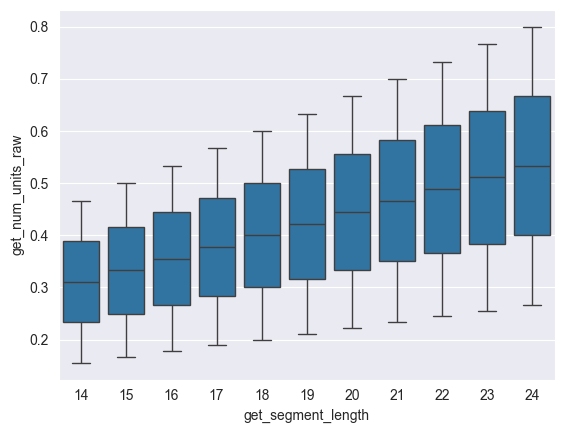

In [315]:
import seaborn as sns
sns.boxplot(data=df_build_stats, x='get_segment_length', y='get_num_units_raw')
plt.savefig("images/segment_length_vs_material_units.png")

### Initial Profit Calculations

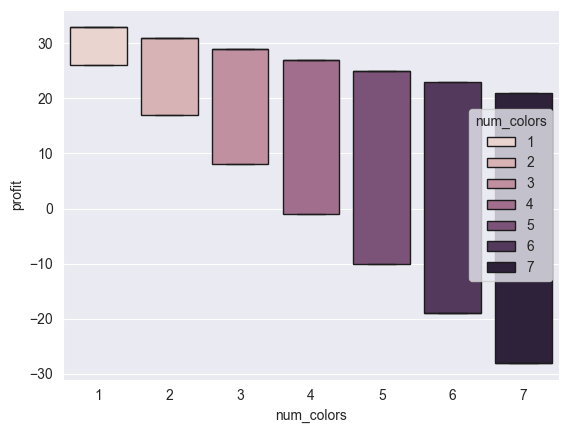

In [316]:
# Check if there is a profit margin in the worst case scenarios.
df_price0 = df.copy()
SHIPPING_PRICE = 7
COST_PER_UNIT = SHIPPING_PRICE + MATERIAL_PRICE
def calculate_profit(df_dimensions,  df_build, cost_per_unit):
    df_price = df_dimensions.copy()
    df_price['price'] = BASE_PRICE + df_price['num_colors'] * COST_PER_COLOR
    df_price['num_units'] = df_build['get_num_units_raw'].round(1) * df_build['num_colors']
    df_price['num_units_rounded'] = np.ceil(df_build['get_num_units_raw'] * 2) / 2 * df_build['num_colors']
    df_price['material_loss'] = df_price['num_units_rounded'] - df_price['num_units']
    df_price['material_length'] = df_build['get_segment_length'] * df_build['get_num_segments']
    df_price['material_cost']= df_price['num_units_rounded'] * cost_per_unit
    df_price['profit']= df_price['price'] - df_price['material_cost']
    return df_price
# Making copy of data for backup
df_price0 = calculate_profit(df_price0, df_build_stats, COST_PER_UNIT)
sns.boxplot(data=df_price0, x='num_colors', y='profit', hue='num_colors')
plt.savefig('images/num_colors_vs_profit0.png')


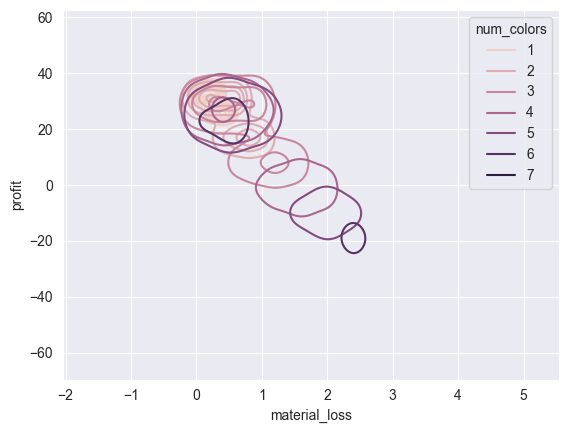

In [317]:
#
sns.kdeplot(data=df_price0, x='material_loss', y='profit', hue='num_colors')
plt.title=f"Material Loss vs Price Original (COST_PER_COLOR = {COST_PER_COLOR})"
plt.savefig("images/material_loss_vs_profit0.png")

#### Observations
- Initial price figures lead to profit going down as number of colors increases, but it doesn't go down for all orders.
- As Material loss goes up profit goes down.
- Some items in this set have stable material_loss as num_colors goes up.
#### Suggestions
- Vendor should do one of the following:
  - 1) Increase their price per color to keep profit from going negative.
  - 2) Figure out what orders have a high material loss and remove those items from the store.
#### Other Notes
- Shipping and handling has a significant impact on final profit margins and may not have been calculated accurately in this chart.

### Updated Prices

#### Recalculating Material Price

In [318]:
BASE_PRICE = 40
COST_PER_COLOR = 10

# Updating price estimates with data from client
MATERIAL_PRICE_LIST = [14.94 / 2, 34.09 / 4, 48.60 / 10, 19.11 / 4] # Pulled from inventory orders
MATERIAL_PRICE = np.mean(MATERIAL_PRICE_LIST)
df_price1 = calculate_profit(df_price0, df_build_stats, MATERIAL_PRICE)
print(f"BASE PRICE: ${BASE_PRICE}")
print(f"COST PRICE: ${COST_PER_COLOR}")
print(f"MATERIAL_PRICE: ${MATERIAL_PRICE.round(2)}")

BASE PRICE: $40
COST PRICE: $10
MATERIAL_PRICE: $6.41


##### Observations
- Clients original material prices was close to accurate so we don't need to redo initial calculation.

#### Rerunning Profit Calculations

Lowest Profit: $43.6
Highest Profit: $87.57
Mean Profit: $59.83
Mean Material Loss: $0.82
Median Profit: $57.96
Hourly Profit: $132.95
Mean Material Loss: $0.82


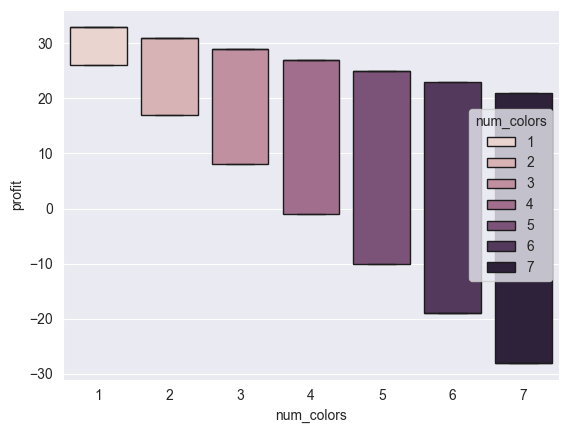

In [319]:
PROCESS_TIME_PER_ORDER = 0.45
print(f"Lowest Profit: ${df_price1.profit.min().round(1)}")
print(f"Highest Profit: ${df_price1.profit.max().round(2)}")
print(f"Mean Profit: ${df_price1.profit.mean().round(2)}")
print(f"Mean Material Loss: ${df_price1.material_loss.mean().round(2)}")
print(f"Median Profit: ${df_price1.profit.median().round(2)}")
print(f"Hourly Profit: ${(df_price1.profit.mean() / PROCESS_TIME_PER_ORDER).round(2)}")
print(f"Mean Material Loss: ${df_price1.material_loss.mean().round(2)}")
sns.boxplot(data=df_price0, x='num_colors', y='profit', hue='num_colors')
plt.savefig('images/num_colors_vs_profit0.png')

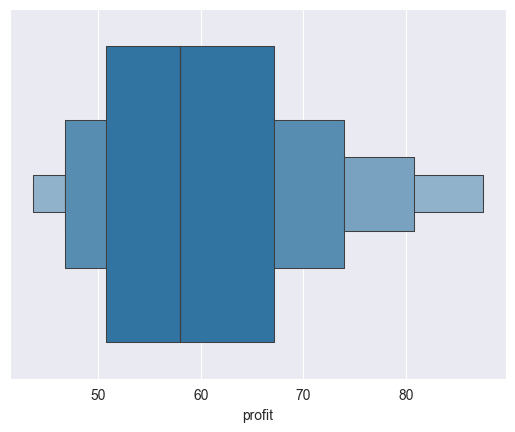

In [320]:
sns.boxenplot(data=df_price1[profit_columns], x='profit')
plt.savefig("images/profit_boxen.png")

##### Observations
- The majority or the orders have a profit value between \\$25 and \\$55 after update.
#### Suggestions
- Client should have a base price of at least \\$40.
- Client should have a per color surcharge of between \\$5 and \\$10

## Material Loss Optimization


### Mean Material Loss

Material Loss: [$0.0 to $3.5]
Material Loss Mean: $0.82


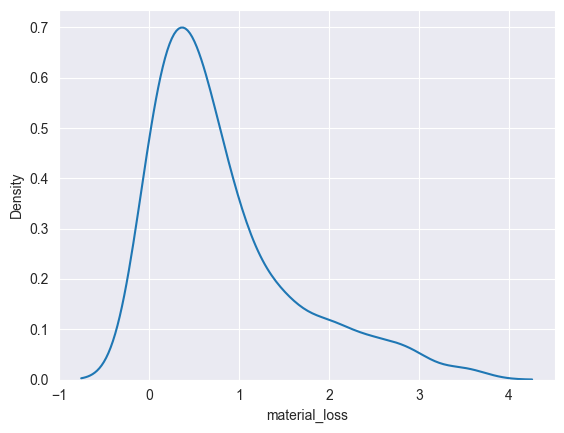

In [321]:
sns.kdeplot(data=df_price0, x='material_loss')
plt.savefig('images/material_loss_density.png')
print(f"Material Loss: [${df_price0['material_loss'].min()} to ${df_price0['material_loss'].max()}]")
print(f"Material Loss Mean: ${df_price0['material_loss'].mean().round(2)}")
# The mean material loss

#### Observations
- Most of the orders have a fairly low material_loss value
- The negative values for material loss are a artifact of the seaborn kde function.

### Num Colors vs. Material Loss

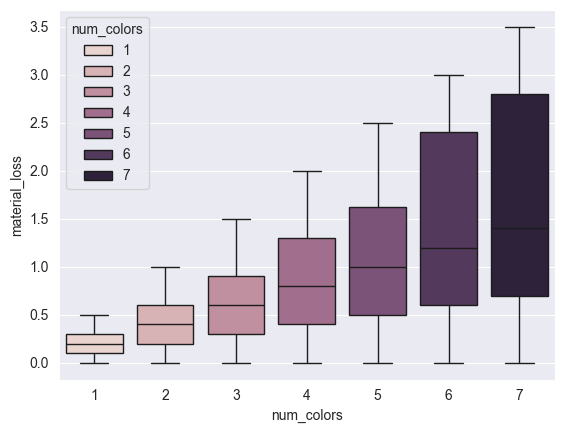

In [322]:
sns.boxplot(data=df_price0, x='num_colors', y='material_loss', hue='num_colors')
plt.savefig('images/material_loss_vs_num_colors1.png')

#### Observations
- Orders with a large number of colors have high variability in their profit margin.
- As num_colors goes up material_loss goes up, but it doesn't go up uniformly across all orders.
#### Suggestions
- If the client can figure out what orders have a low material loss values profit could be increased significantly.


### Material Loss vs. Profit

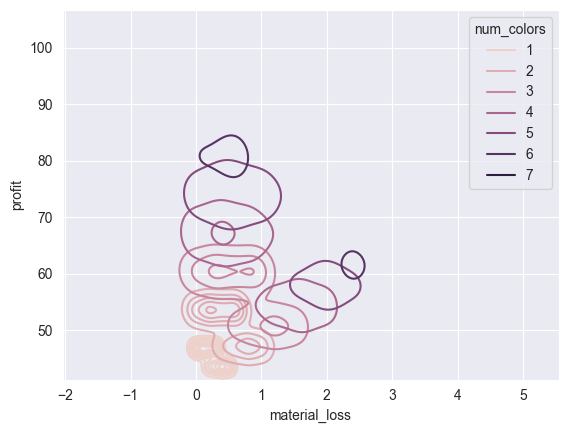

In [323]:
sns.kdeplot(data=df_price1, x='material_loss', y='profit', hue='num_colors')
plt.savefig("images/material_loss_vs_profit1.png")


#### Observations
- Two trend lines can be seen on this chart one for orders with a high material loss and one for orders with a low value.
- The per color surcharge is enough to overcome the higher material loss for orders with multiple colors.
- Items with low material loss values have significantly higher profit margins.
- Additional Notes
   - Projects with multiple colors will have a small amount of scrap material in each color so the calculated material loss value may be off.
   - Scrap from one product could be used in future projects which is something these charts are unable to account for.

### Material Loss Scatter Plots

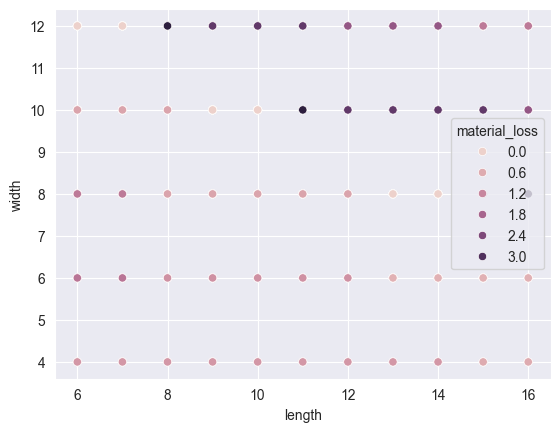

In [324]:
# Moving the material loss value back to original df for analysis
material_loss_columns = ['length', 'width', 'num_colors', 'material_loss']
df_build_stats['material_loss'] = df_price0['material_loss']

sns.scatterplot(data=df_build_stats[material_loss_columns], x='length', y='width', hue='material_loss')
plt.savefig("images/material_loss_ideal_dimensions.png")

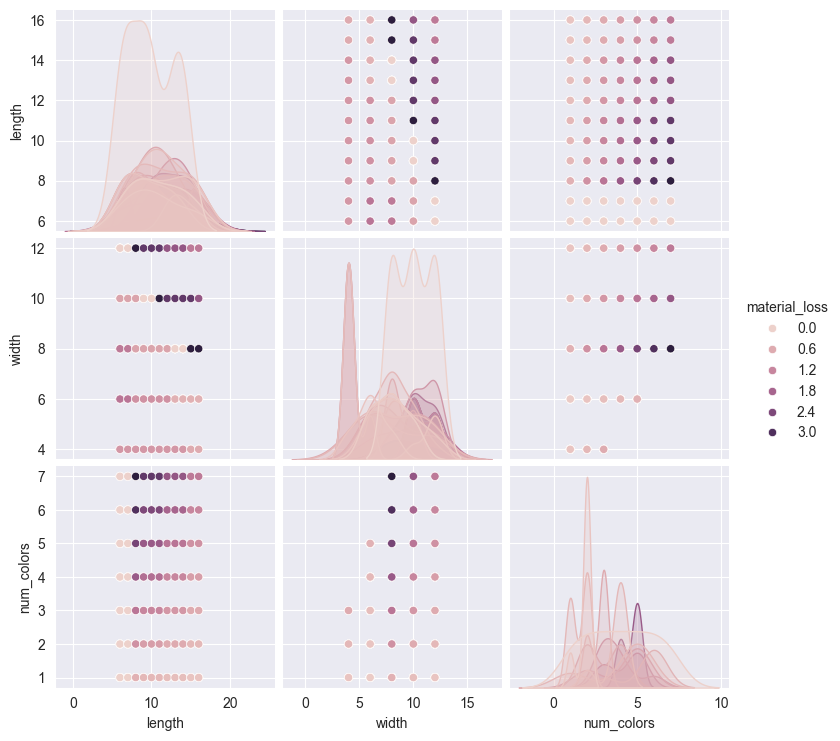

In [325]:
sns.pairplot(data=df_build_stats[material_loss_columns], hue='material_loss')
plt.savefig('images/material_loss_pair_plot.png');


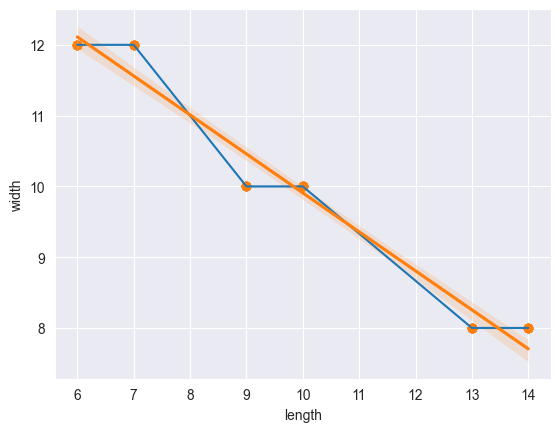

In [326]:
df_zero_loss = df_build_stats[df_build_stats['material_loss'] == 0]
sns.lineplot(data=df_zero_loss[material_loss_columns], x='length', y='width')
sns.regplot(data=df_zero_loss[material_loss_columns], x='length', y='width')
plt.savefig("images/ideal_dimensions_using_material_loss.png")

#### Observations
- There seems to be an optimal set of values for length and width parameters that will minimize material loss.
- Orders with length or width of 6 have the least waste.
- For the optimal material_loss values length + width should be less than 20.
- If the customer only specifies one value in their request we can use this equation to calculate the other value.

## Final Thoughts
- Based on the profit vs num_color plots the optimal price for our products is 40 per order and 10 extra per color.
- Orders with large number of colors are likely to have higher material loss, but also have a potential for higher profit.
- If the client wants to minimize material loss they should only offer products whose dimensions add up to less than 20.

##### Author
- Product Profitability Report
- Daniel Levenstein
- Date: 09/16/2025